<div align="center">
  <img src="Bases/logoMoSEF.jpeg" width="90px" align="left">
  <div align="right">Enseignant : Nexialog</div>
  <div align="right">Réalisé par : Seçil Coskun, ABABII Anisoara, Eunice KOFFI et DIAKITE Gaoussou</div>
  <div align="right">Année : 2022/2023</div>
  <br><br><br>
  <div align="center">
    <span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Master 2 Modélisation Statistiques Economiques et Financières</span>
  </div>
  <br>
  <div align="center">
    <span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Université Paris 1 Panthéon-Sorbonne</span>
  </div>
  <br>
  <div align="center">
    <span style="font-family:Lucida Caligraphy;font-size:28px;background-color:#F5DEB3;padding:5px;border-radius:10px">Challenge Nexialog</span>
  </div>
  <br><br>
  <hr>
  <div align="center">
    <h1 style="font-size: 30px">Partie 3 : Modèle Challengers</h1>
    <p style="font-size: 20px;color:#696969">Après avoir testé plusieurs modèles challengers pour prédire le taux de défaut sur différents scénarios macroéconomiques (baseline et adverse), nous avons finalement sélectionné le modèle Random Forest pour sa performance supérieure. Ce notebook présente en détail les  modèles challengers que nous avons utilisés pour prédire le taux de défaut, ainsi que les hypothèses vérifiées et le graphique de la prédiction finale.</p>
  </div>
</div>


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px;color:darkgreen"> <span style="color:green">      
IMPORTATION DES LIBRAIRIES</span>

In [1]:
#Librairie 
# suppression des warning 
import warnings
warnings.filterwarnings('ignore')

# Importation des librairie 
import pandas as pd
import numpy as np

# Data Visualisation
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns

#Modélisation 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.discrete.discrete_model

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import CooksDistance

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Lecture des bases</span>


In [2]:
date_q = pd.read_excel('Bases/date_quarterly.xlsx')
default_rate = pd.read_excel('Bases/default_rate_quarterly.xlsx', index_col='Date')
var_macro_adverse = pd.read_excel('Bases/variables_macroeconomiques_adverse.xlsx', index_col='Date')
var_macro = pd.read_excel('Bases/variables_macroeconomiques.xlsx', index_col='Date')
var_macro_baseline = pd.read_excel('Bases/variables_macroeconomiques_baseline.xlsx',index_col='Date')

<hr style="border-width:2px;border-color:green">
<center><h1>Preprocessing</h1></center>
<hr style="border-width:2px;border-color:green">

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Calculer le taux de croissance Annuelle</span>

In [3]:

def taux_croissance(df):
    series_en_volume = df.columns
    df = df.dropna()
    for col in df.columns :
        df[f'gr_{col}'] = (df[col] - df[col].shift(4)) / df[col].shift(4)
    df = df.dropna()
    df = df.drop(list(series_en_volume), axis = 1)
    return df


var_macro = taux_croissance(var_macro)

In [4]:
var_macro = pd.concat([var_macro, default_rate], axis = 1)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Introduction des lags</span>
    




In [5]:
def create_lags_diffs(data, num_lags=1):
    new_data = pd.DataFrame()
    
    # Create lags
    for col in data.columns :
        for i in range(1, num_lags+1):
            new_data[f"{col}_lag{i}"] = data[col].shift(i)

        # Drop any rows with missing values
    new_data = pd.concat([data, new_data], axis = 1)
    new_data = new_data.dropna()
            
    return new_data

In [6]:
var_macro_lags = create_lags_diffs(var_macro, num_lags = 4)
var_macro_lags = var_macro_lags.drop(columns = ["DR_lag2", "DR_lag3", "DR_lag4"])
var_macro_lags.head()

,gr_RGDP,gr_HICP,gr_RREP,gr_IRLT,gr_UNR,DR,gr_RGDP_lag1,gr_RGDP_lag2,gr_RGDP_lag3,gr_RGDP_lag4,...,gr_RREP_lag4,gr_IRLT_lag1,gr_IRLT_lag2,gr_IRLT_lag3,gr_IRLT_lag4,gr_UNR_lag1,gr_UNR_lag2,gr_UNR_lag3,gr_UNR_lag4,DR_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.015567,0.029064,0.023749,0.210000,-0.067907,0.047990,0.022698,0.020576,0.018300,0.019352,...,-0.010740,0.159314,-0.073171,-0.077803,-0.082569,-0.059051,0.011847,0.038192,0.134846,0.049466
2011-04-30,0.005452,0.020607,0.012626,0.354839,0.020272,0.047582,0.015567,0.022698,0.020576,0.018300,...,-0.004692,0.210000,0.159314,-0.073171,-0.077803,-0.067907,-0.059051,0.011847,0.038192,0.047990
2011-07-31,-0.009517,0.037393,0.005046,0.571053,0.108471,0.048630,0.005452,0.015567,0.022698,0.020576,...,0.002614,0.354839,0.210000,0.159314,-0.073171,0.020272,-0.067907,-0.059051,0.011847,0.047582
2011-10-31,-0.024919,0.033514,0.005917,0.382664,0.276238,0.043486,-0.009517,0.005452,0.015567,0.022698,...,0.012842,0.571053,0.354839,0.210000,0.159314,0.108471,0.020272,-0.067907,-0.059051,0.048630
2012-01-31,-0.032554,0.036611,-0.021541,0.173554,0.341834,0.043242,-0.024919,-0.009517,0.005452,0.015567,...,0.023749,0.382664,0.571053,0.354839,0.210000,0.276238,0.108471,0.020272,-0.067907,0.043486


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Split de la base de données</span>


In [7]:
X = var_macro_lags.drop('DR', axis=1)
y = var_macro_lags['DR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<hr style="border-width:2px;border-color:green">
<center><h1>Modèle : Random Forest Regressor</h1></center>
<hr style="border-width:2px;border-color:green">

=====RandomForestRegressor=====
Score Test: 0.9501821382536685
MAE: 0.001960689789031444
MSE: 5.455946174159212e-06


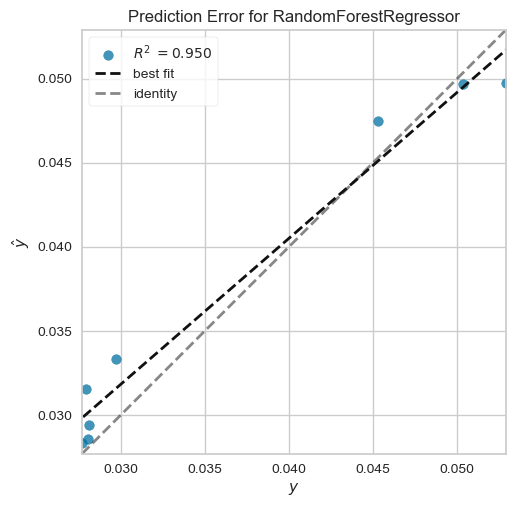

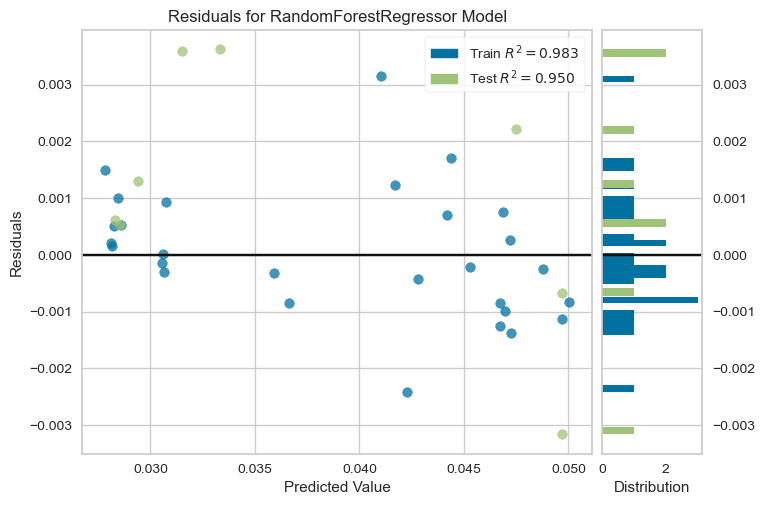

In [8]:
np.random.seed(42)
gb = RandomForestRegressor()
gb.fit(X_train,y_train)
print("=====RandomForestRegressor=====")
print("Score Test:",gb.score(X_test,y_test))
pred_gb = gb.predict(X_test)
print("MAE:",mean_absolute_error(y_test,pred_gb))
print("MSE:",mean_squared_error(y_test,pred_gb))

visualizer = PredictionError(gb)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.show(); 

visualizer = ResidualsPlot(gb)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

<hr style="border-width:2px;border-color:green">
<center><h1>Modèle : Test des hypothèses</h1></center>
<hr style="border-width:2px;border-color:green">

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Test de Jarque-Bera sur les résidus</span>

Dans le cadre de l'évaluation de la performance de notre modèle de prédiction de taux de défaut, nous avons effectué un test de Jarque-Bera sur les résidus de la prédiction. Ce test est utilisé pour vérifier si les résidus de la prédiction suivent une distribution normale.

In [9]:
from scipy import stats

# Calculer les résidus
residus = y_test - pred_gb

# Effectuer le test de Jarque-Bera sur les résidus
jb_stat, jb_p_value = stats.jarque_bera(residus)

# Afficher les résultats du test de Jarque-Bera
print("Statistique de test de Jarque-Bera :", jb_stat)
print("Valeur p du test de Jarque-Bera :", jb_p_value)

Statistique de test de Jarque-Bera : 0.4505121139567903
Valeur p du test de Jarque-Bera : 0.7983117792843961


# commentaire :

Après avoir effectué le test de Jarque-Bera sur les résidus de notre prédiction de taux de défaut, nous avons obtenu une statistique de test de 0.4505 et une valeur p de 0.7983. Étant donné que la valeur p est supérieure à notre seuil de signification de 0,05, nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle les résidus suivent une distribution normale. Cela indique que notre modèle de prédiction de taux de défaut a des résidus qui suivent une distribution normale, ce qui est un critère important pour valider la précision de notre modèle.


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Test de Shapiro-Wilk</span>

Le test de Shapiro-Wilk a été utilisé pour vérifier si les résidus suivent une distribution normale. La statistique de test obtenue est de 0.94 avec une valeur p de 0.61, ce qui indique que les résidus ne s'éloignent pas significativement d'une distribution normale. Cela suggère que le modèle de prédiction utilisé est fiable pour les données testées.

In [10]:
# Effectuer le test de Shapiro-Wilk sur les résidus
shapiro_stat, shapiro_p_value = stats.shapiro(residus)

# Afficher les résultats du test de Shapiro-Wilk
print("Statistique de test de Shapiro-Wilk :", shapiro_stat)
print("Valeur p du test de Shapiro-Wilk :", shapiro_p_value)

Statistique de test de Shapiro-Wilk : 0.939935028553009
Valeur p du test de Shapiro-Wilk : 0.6104410886764526



<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Effectuer le test de Breusch-Pagan pour l'hétéroscédasticité</span>

Ce test utilise le test de Breusch-Pagan pour vérifier l'hétéroscédasticité des résidus de notre modèle de régression. Dans ce cas, la statistique de test de Breusch-Pagan est de 8.0 avec une valeur p de 0.9994949447885928. Cela signifie que nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle il n'y a pas d'hétéroscédasticité dans nos résidus.

In [11]:
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from sklearn.ensemble import RandomForestRegressor

# Effectuer le test de Breusch-Pagan pour l'hétéroscédasticité
bp_stat, bp_p_value, _, _ = het_breuschpagan(residus, X_test)

# Afficher les résultats des tests
print("Statistique de test de Breusch-Pagan (hétéroscédasticité) :", bp_stat)
print("Valeur p du test de Breusch-Pagan (hétéroscédasticité) :", bp_p_value)

Statistique de test de Breusch-Pagan (hétéroscédasticité) : 8.0
Valeur p du test de Breusch-Pagan (hétéroscédasticité) : 0.9994949447885928



<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Effectuer le test de Ljung-Box pour l'autocorrélation</span>

Le test de Ljung-Box a été effectué pour vérifier la présence d'autocorrélation dans les résidus de prédiction du modèle. Les résidus ont été calculés en soustrayant les prédictions du modèle des vraies valeurs de test. Le résultat du test montre une statistique de test de Ljung-Box de 1.72228184 et une valeur p de 0.18939959. Cela indique qu'il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle selon laquelle il n'y a pas d'autocorrélation dans les résidus.

In [12]:
# Effectuer le test de Ljung-Box pour l'autocorrélation
# Calculer les résidus
residus = y_test - pred_gb
lb_stat, lb_p_value = acorr_ljungbox(residus).T.values

# Afficher les résultats des tests
print("Statistique de test de Ljung-Box (autocorrélation) :", lb_stat)
print("Valeur p du test de Ljung-Box (autocorrélation) :", lb_p_value)

Statistique de test de Ljung-Box (autocorrélation) : [1.72228184]
Valeur p du test de Ljung-Box (autocorrélation) : [0.18939959]


In [13]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test

print(durbin_watson(residus))

1.7158572116774768


Le test Durbin-Watson a renvoyé un résultat de 1.7158572116774768. Cela suggère qu'il y a une légère autocorrélation positive dans les résidus, mais cela reste faible.


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Importance des variables</span>

In [14]:
importance = gb.feature_importances_
indices = np.argsort(importance)[::-1]
significant_features = []
for f in range(X_train.shape[1]):
    if importance[indices[f]] > 0.01:
        significant_features.append(X_train.columns[indices[f]])
        print("%d) %s (%f)" % (f + 1, X_train.columns[indices[f]], importance[indices[f]]))


1) DR_lag1 (0.806636)
2) gr_UNR (0.027692)
3) gr_UNR_lag4 (0.023210)
4) gr_RGDP (0.020173)
5) gr_RREP_lag4 (0.011815)
6) gr_UNR_lag3 (0.011038)
7) gr_IRLT_lag4 (0.010678)
8) gr_RGDP_lag1 (0.010018)


In [15]:
X = var_macro_lags[['DR_lag1',
 'gr_UNR',
 'gr_UNR_lag4',
 'gr_RGDP',
 'gr_RREP_lag4',
 'gr_UNR_lag3',
 'gr_IRLT_lag4',
 'gr_RGDP_lag1']]
y = var_macro_lags['DR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Nouveau modèle avec les variables significatives</span>

=====RandomForestRegressor=====
Score Test: 0.9486217110378012
MAE: 0.0018680703764179202
MSE: 5.626840841253028e-06


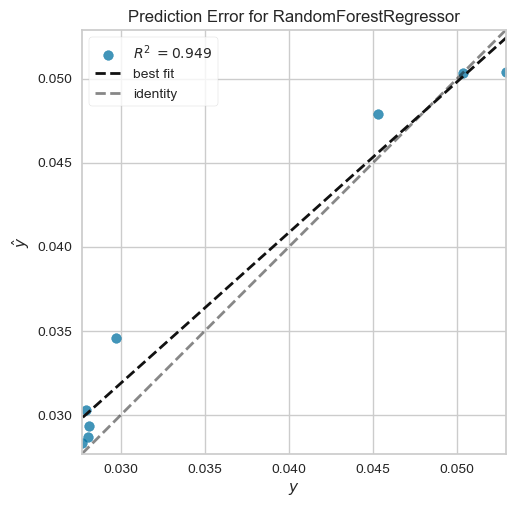

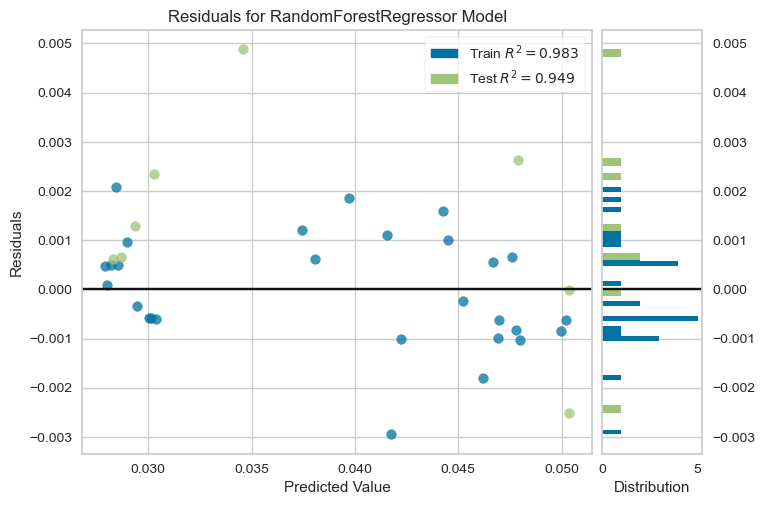

In [16]:
gb = RandomForestRegressor()
gb.fit(X_train,y_train)
print("=====RandomForestRegressor=====")
print("Score Test:",gb.score(X_test,y_test))
pred_gb = gb.predict(X_test)
print("MAE:",mean_absolute_error(y_test,pred_gb))
print("MSE:",mean_squared_error(y_test,pred_gb))

visualizer = PredictionError(gb)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.show(); 

visualizer = ResidualsPlot(gb)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

<hr style="border-width:2px;border-color:green">
<center><h1>Application du modèle sur différents scénarios</h1></center>
<hr style="border-width:2px;border-color:green">

In [17]:
var_macro_adverse.head()

,RGDP,HICP,RREP,IRLT,UNR
Date,,,,,
2018-01-31,-0.6,0.8,-7.3,3.3,11.3
2018-04-30,-0.6,0.8,-7.3,3.3,11.3
2018-07-31,-0.6,0.8,-7.3,3.3,11.3
2018-10-31,-0.6,0.8,-7.3,3.3,11.3
2019-01-31,-1.5,0.8,-4.9,3.7,11.9


In [18]:
#on supprime Dr_lag1 dans la liste des variables significatives 
significant_features.remove('DR_lag1')

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Calculer le taux de croissance Annuelle, introduction des lags et selections des variables significatives</span>

In [19]:
var_macro_adverse1 = taux_croissance(var_macro_adverse)
var_macro_adverse1 = create_lags_diffs(var_macro_adverse1, num_lags = 4)
var_macro_adverse1 = var_macro_adverse1[significant_features]

In [20]:
significant_features

['gr_UNR',
 'gr_UNR_lag4',
 'gr_RGDP',
 'gr_RREP_lag4',
 'gr_UNR_lag3',
 'gr_IRLT_lag4',
 'gr_RGDP_lag1']


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Prévision</span>

In [21]:
scenarios_taux = taux_croissance(var_macro_adverse)
var_macro_adverse = pd.concat([scenarios_taux["gr_UNR"], var_macro_adverse.drop(columns = ["UNR"])], axis = 1).dropna()
var_macro_adverse = var_macro_adverse.rename(columns= {"RGDP":"gr_RGDP", "HICP":"gr_HICP", "RREP":"gr_RREP", "IRLT":"gr_IRLT"})
var_macro_adverse[["gr_RGDP" ,"gr_HICP" ,"gr_RREP"]] = var_macro_adverse[["gr_RGDP" ,"gr_HICP" ,"gr_RREP"]] / 100
var_macro_adverse["gr_IRLT"] = var_macro_adverse["gr_IRLT"] / 10

scenarios_taux = taux_croissance(var_macro_baseline)
var_macro_baseline = pd.concat([scenarios_taux["gr_UNR"], var_macro_baseline.drop(columns = ["UNR"])], axis = 1).dropna()
var_macro_baseline = var_macro_baseline.rename(columns= {"RGDP":"gr_RGDP", "HICP":"gr_HICP", "RREP":"gr_RREP", "IRLT":"gr_IRLT"})
var_macro_baseline[["gr_RGDP" ,"gr_HICP" ,"gr_RREP"]] = var_macro_baseline[["gr_RGDP" ,"gr_HICP" ,"gr_RREP"]] / 100
var_macro_baseline["gr_IRLT"] = var_macro_baseline["gr_IRLT"] / 10

In [22]:
def prediction_modele_176(scenario) : 
    sc = create_lags_diffs(scenario, num_lags = 4)
    X1 = pd.concat([var_macro_lags[-1:]["gr_UNR"], sc["gr_UNR"]]) #on concatene la derniere valeur dispo dans la base (2019-10-31) avec les valeurs du scénario
    X2 = pd.concat([var_macro_lags[-1:]["gr_RGDP"], sc["gr_RGDP"]])
    X3 = pd.concat([var_macro_lags[-1:]["gr_RGDP_lag1"], sc["gr_RGDP_lag1"]])
    X4 = pd.concat([var_macro_lags[-1:]["gr_UNR_lag3"], sc["gr_UNR_lag3"]])
    X5 = pd.concat([var_macro_lags[-1:]["gr_RREP_lag4"], sc["gr_RREP_lag4"]])
    X6 = pd.concat([var_macro_lags[-1:]["gr_UNR_lag4"], sc["gr_UNR_lag4"]])
    X7 = pd.concat([var_macro_lags[-1:]["gr_IRLT_lag4"], sc["gr_IRLT_lag4"]])#on concatene la derniere valeur dispo dans la base (2019-10-31) avec les valeurs du scénario
    X = pd.concat([X1,X2, X3, X4, X5, X6, X7, var_macro_lags[-1:]["DR_lag1"], var_macro_lags[-1:]["DR"]], axis = 1 ) #on rajoute la 2ème et 3eme variable explicative
    dates =  X.index.date.astype(str).tolist()

    for i in range (len(dates)-1) :
        X_1 = pd.DataFrame(X.loc[dates[i]][['DR_lag1', 'gr_UNR', 'gr_UNR_lag4', 'gr_RGDP', 'gr_RREP_lag4', 'gr_UNR_lag3', 'gr_IRLT_lag4', 'gr_RGDP_lag1']]).T # au début on retient juste 2019-10-31 pour calculer la date d'apres, etc.
        sc_predictions = gb.predict(X_1)
        sc_predictions = pd.DataFrame(sc_predictions, columns = ["DR_pred"])
        X.loc[dates[i+1]]['DR'] = sc_predictions["DR_pred"]
        X["DR_lag1"] = X["DR"].shift(1)
        
    serie_predite = X.loc[X.index > '2019-10-31']["DR"]
    serie_predite_et_val_precente = X.loc[X.index > '2019-07-31']["DR"] #pour qu'il y ait pas de trou dans le plot dû aux dates
    return serie_predite_et_val_precente

prediction_modele_176(var_macro_baseline)

Date
2019-10-31    0.027948
2020-01-31    0.030302
2020-04-30    0.028169
2020-07-31    0.028364
2020-10-31    0.028392
Freq: Q-OCT, Name: DR, dtype: float64



<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Plot des prédictions</span>

-------------------- Scénarios adverse --------------------


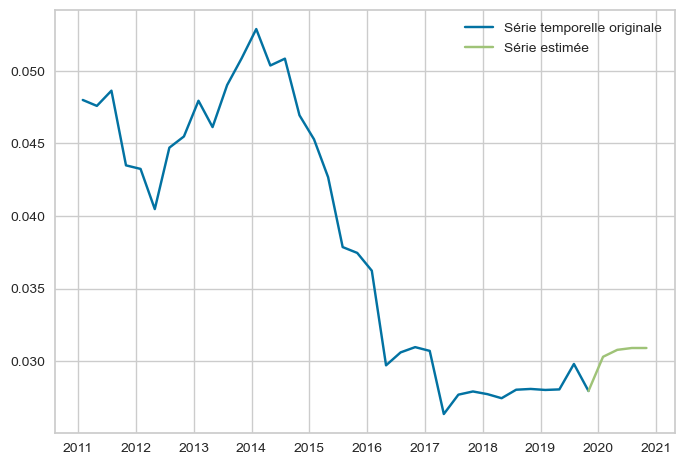

-------------------- Scénarios baseline --------------------


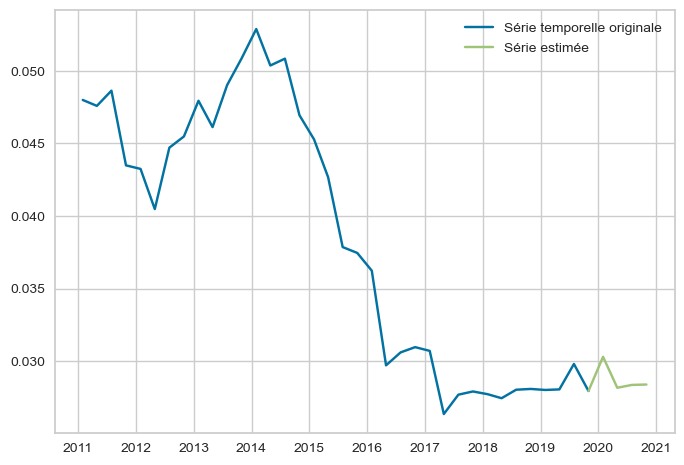

In [23]:
print(20*"-", "Scénarios adverse", 20*"-")
pred_gb_base_adv = prediction_modele_176(var_macro_adverse)
plt.plot(y, label='Série temporelle originale')
plt.plot(pred_gb_base_adv, label='Série estimée')
plt.legend()
plt.show() 

print(20*"-", "Scénarios baseline", 20*"-")
pred_gb_base_base = prediction_modele_176(var_macro_baseline)
plt.plot(y, label='Série temporelle originale')
plt.plot(pred_gb_base_base, label='Série estimée')
plt.legend()
plt.show()